# Rusty Bargain - Vehicle Value Predictions

Rusty Bargain is a used car service that is developing an application to attract new customers. The purpose of the application is to allow individuals to quickly find out the market value of their car. For this project, we have access to historical data, including the technical specifications of various vehicles, trim versions, and vehicle prices. Our goal is to build a machine learning model that predicts the value of a vehicle. Rust Bargain is particularly interested in a model that can be quickly trained, produces accurate results, and is quick when making predictions.

## Import Libraries and Preprocess the Data

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import math
import time
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
try:
    cars = pd.read_csv('/car_data.csv')
except:
    cars = pd.read_csv('https://code.s3.yandex.net/datasets/car_data.csv')

### Preprocess the Data

#### Format Column Names

In [3]:
#Make all columns lowercase.
cars.columns = cars.columns.str.lower()

#### Inspect Data

In [4]:
#Print description of numerical variables.
print('Description of numerical variables:')
display(cars.describe())

Description of numerical variables:


,price,registrationyear,power,mileage,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


1.3.2 Notes: From the above DataFrame description, a few key things stand out:
        
    1) price - There appear to be cars listed as valued at 0. While this may indicate that there was an error in inputting the vehicles' prices, it may also be that the vehicles are in such poor condition that they are practically worthless. We will deal with these values in a subsequent section.
    
    2) registrationyear - There are clear invalid values in this column. For example, the minimum registration year is 1000 and the maximum is 9999. Obviously these are incorrect and must be dealt with.
    
    3) power - The average vehicle horsepower is between 180 and 200. As such, the max value of 20,000 appears incorrect. The minimum value of 0 may indicate that a vehicle no longer functions, or may represent an error in the data.
    
    4) mileage - It appears that the average mileage of a vehicle in the dataset is 150,000. This is also the max value in the dataset. We believe that Rusty Bargain's system may simply set 150,000 as the upper bound and use this value for any vehicle that is reported as having a higher mileage.
    
    5) numberofpictures & postalcode - These both appear to be irrelevant features with regard to building our model; as such, they will be removed.

In [5]:
#Print info on DataFrame.
print('Information for Cars DataFrame:\n')
print(cars.info())

Information for Cars DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null 

In [6]:
#Get value counts for datecrawled years for future reference.
cars.datecrawled = pd.to_datetime(cars.datecrawled, infer_datetime_format=True)
print(cars.datecrawled.dt.year.value_counts())

2016    354369
Name: datecrawled, dtype: int64


1.3.2 Notes Continued: There are 354,369 entries in this DataFrame. We can see from the Non_null count in the info that many columns have NaNs; we will deal with these in a subsequent subsection. We also believe that 'datecrawled', 'datecreated', and 'lastseen' are irrelevant features and should be dropped. Although we believe that 'datecrawled' should be dropped, we decided to change its data type and obtain a value count for the years represented; this was done to aid in our later filtering out vehicles with incorrect 'registrationyear' values from our dataset. With the aforementioned irrelevant features dropped, all columns would be of the proper datatype. 

#### Drop Irrelevant Columns

In [7]:
#Drop irrelevant columns from DataFrame.
cars.drop(columns=['datecrawled', 'datecreated', 'lastseen', 'numberofpictures', 'postalcode'], inplace=True)

#### Check for Duplicates

In [8]:
#Check dataset for duplicate rows
print(f'The number of duplicated rows in the dataset is: {cars.duplicated().sum()}')

The number of duplicated rows in the dataset is: 27543


1.3.4 Notes: We found that there are 27,543 duplicates in this dataset. If we don't remove them, they could bias our future machine learning models. As such, we will drop the duplicates and reset the DataFrame's index.


In [9]:
#Drop duplicates
cars.drop_duplicates(inplace=True)
cars.reset_index(drop=True) ;

#### Deal With Possible Incorrect Values

In this subsection we will consider the best ways to deal with what we believe to be incorrect values, as mentioned in subsection 1.3.2.

##### Price

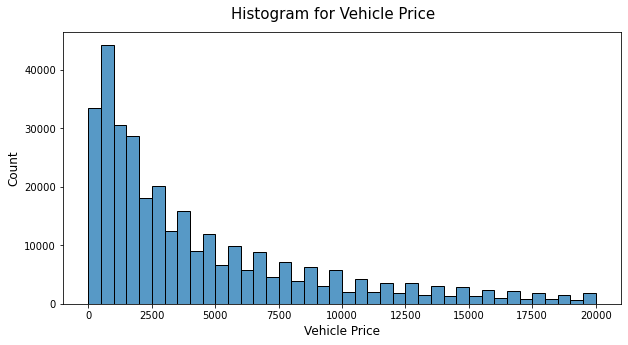

In [10]:
#Create histogram to visualize price distribution.
fig = plt.figure(figsize=(10, 5))
plt.suptitle('Histogram for Vehicle Price', fontsize=15, y=.95)
sns.histplot(cars.price, bins=40)
plt.xlabel('Vehicle Price', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [11]:
#Obtain count for vechiles listed as $0.
print(f'Proportion of vehicles listed as costing $0: {round(len(cars.loc[cars.price == 0]) / len(cars), 2)}%')

Proportion of vehicles listed as costing $0: 0.03%


1.3.5.1 Notes: Given how little of the dataset is comprised of vehicles listed for $0, we believe it is appropriate to simply drop these data points.

In [12]:
#Drop vechiles listed for $0 from dataset.
cars = cars.loc[cars['price'] > 0]
cars.reset_index(drop=True, inplace=True)

##### Registration Year

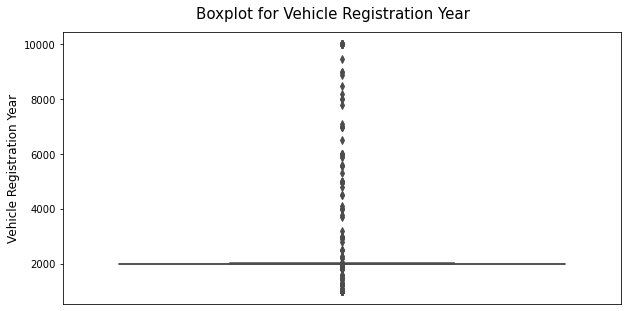

In [13]:
#Create boxplot to visualize registrationyear distribution.
fig = plt.figure(figsize=(10, 5))
plt.suptitle('Boxplot for Vehicle Registration Year', fontsize=15, y=.95)
sns.boxplot(data=cars.registrationyear, color='blue')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel('')
plt.ylabel('Vehicle Registration Year', fontsize=12)
plt.show()

1.3.5.2 Notes: From the boxplot, we can clearly see that most of the values are around 2000, though there are many outliers. We believe that the most suitable method for removing the outliers is to use the interquartile range. We will create a function that calculates the interquartile range (IQR) and removes any values 1.5 times the IQR above the third quartile and below the first quartile.

In [14]:
#Create function to remove outliers.
def remove_outliers(df, column):
    iqr = st.iqr(df[column])
    q1, q3 = np.quantile(df[column], [.25, .75])
    df = df.loc[(df[column] >= q1 - (1.5 * iqr)) & (df[column] <= q3 + (1.5 * iqr))]
    return df

In [15]:
#Remove outliers from 'registrationyear' column.
cars = remove_outliers(cars, 'registrationyear')

In [16]:
#Obtain description of vechile registration year data.
print(cars.registrationyear.describe())

count    311900.000000
mean       2003.629987
std           6.371030
min        1986.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registrationyear, dtype: float64


1.3.5.2 Notes Continued: Whereas our 'registrationyear' values now appear to be in the appropriate range, the max values represented are 2019. As we saw in subsection 1.3.2, 2016 was the only year represented in the 'datecrawled' column, which means that it should not contain information for vehicles registered past 2016. Because of this, we believe it is appropriate to drop all vehicles with registration years past 2016 from our dataset, so long as the number of such vehicles does not comprise a large portion of our dataset. 

In [17]:
#Print proportion of vehicles with registrationyear value above 2016.
print(f'Proportion of vechiles with registrationyear value above 2016: \
      {round(len(cars.loc[cars.registrationyear > 2016]) / len(cars), 2)}%')

Proportion of vechiles with registrationyear value above 2016:       0.04%


In [18]:
#Drop vehicles from dataset with registrationyear values above 2016.
cars = cars.loc[cars['registrationyear'] <= 2016]
cars.reset_index(drop=True, inplace=True)

##### Power

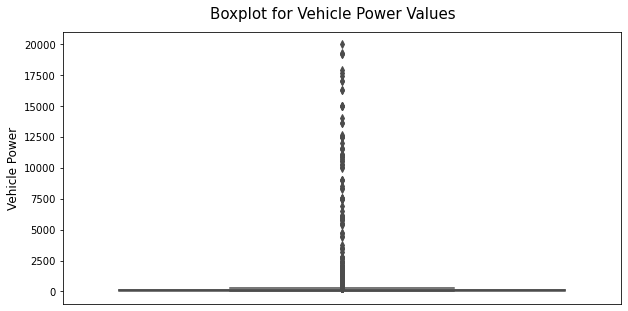

In [19]:
#Create boxplot to visualize vehicle power distribution.
fig = plt.figure(figsize=(10, 5))
plt.suptitle('Boxplot for Vehicle Power Values', fontsize=15, y=.95)
sns.boxplot(data=cars.power, color='blue')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel('')
plt.ylabel('Vehicle Power', fontsize=12)
plt.show()

1.3.5.3 Notes: We can see from the boxplot that most of the values for 'power' are within an expected range - that is, around the 100-200 area. There are, however, a few outliers. These might be due to human error, or be the result of high-power specialty racing vehicles being represented in the dataset. We believe that it would be appropriate to drop these vehicles from the dataset either way.

In [20]:
#Remove outliers from 'power' column.
cars = remove_outliers(cars, 'power')

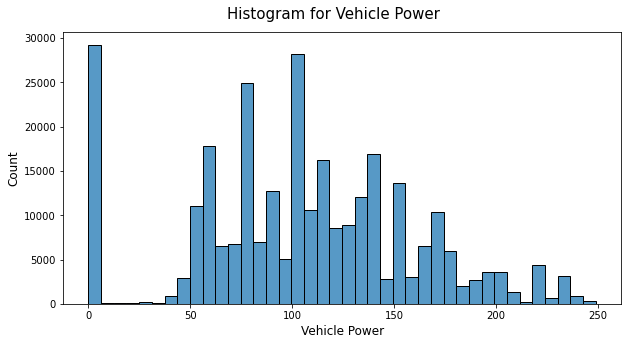

In [21]:
#Create histogram to visualize power distribution.
fig = plt.figure(figsize=(10, 5))
plt.suptitle('Histogram for Vehicle Power', fontsize=15, y=.95)
sns.histplot(cars.power, bins=40)
plt.xlabel('Vehicle Power', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

1.3.5.3 Continued: As can be seen from the above histogram, we did not remove all outliers for 'power' with our function. This is because, due to the distribution of data, 0 was above 1.5 times the IRQ below the first quartile, which means it was not filtered out. A 0 for vehicle power may either be the result of human error or perhaps the vehicle being totaled. Nonetheless, to ensure the integrity of our model, we believe it best to remove such vehicles from our dataset.

In [22]:
#Remove vechiles with 0 for power from our dataset.
cars = cars.loc[cars['power'] > 0]
cars.reset_index(drop=True, inplace=True)

#### Deal with NaNs

In [23]:
#Print the number of NaNs in DataFrame.
print('Total NaNs in each column:')
print(cars.isna().sum())

Total NaNs in each column:
price                    0
vehicletype          10337
registrationyear         0
gearbox               4982
power                    0
model                 9703
mileage                  0
registrationmonth        0
fueltype             14623
brand                    0
notrepaired          39126
dtype: int64


1.3.6 Notes: As we can see, all of the features with NaNs are comprised of categorical variables. We will attempt to fill most of these NaNs by grouping by model and filling the missing value with the most popular feature value in that group. To get a quick feel for the values in 'model', we will view the value counts for the series.

In [24]:
#Print value counts for 'model'
display(cars.model.value_counts())

golf          22020
other         16680
3er           15526
polo           9718
corsa          9125
              ...  
kalina            4
6er               4
rangerover        2
cayenne           2
911               2
Name: model, Length: 246, dtype: int64

1.3.6 Notes Continued: From our value counts, we can see that there are approximately 250 models listed. We also see that one of the most popular models is 'other'. This is odd, and could lead to errors when filling NaNs based on model, since it is unclear what sorts of vehicles fit under 'other'. Since, in our opinion, most of the categorical values are dependent on the model of vehicle, in order to ensure the integrity of the data we will drop all NaNs in the 'model' column, as well as vehicles of the type 'other'.

In [25]:
#Drop rows from dataset with 'model' values of NaN or 'other'
cars = cars.loc[(cars['model'].notnull()) & (cars['model'] != 'other')]
cars.reset_index(drop=True, inplace=True)

##### Fill NaNs for 'vehicletype'

In [26]:
#Fill NaNs for 'vehicletype' by model
cars.vehicletype = cars.vehicletype.fillna(cars.groupby(['model'])['vehicletype'] \
                                           .transform(lambda x: x.value_counts().index[0]))

##### Fill NaNs for 'gearbox'

In [27]:
#Fill NaNs for 'gearbox' by model
cars.gearbox = cars.gearbox.fillna(cars.groupby(['model'])['gearbox'] \
                                             .transform(lambda x: x.value_counts().index[0]))

##### Fill NaNs for 'fueltype'

In [28]:
#Fill NaNs for 'fueltype' by model
cars.fueltype = cars.fueltype.fillna(cars.groupby(['model'])['fueltype'] \
                                             .transform(lambda x: x.value_counts().index[0]))

##### Fill NaNs for 'notrepaired'

Since whether a vehicle has been repaired or not is not affected by the vehicle's model, we can not use the same method to replace the missing values in the relevant column. Nonetheless, it may be possible to fill the NaNs according to price. Typically, when a vehicle has been repaired, the value of the vehicle is reduced. To see if this holds true for our dataset, we will visualize our data using a boxplot. If we find that there is a clear difference in price between vehicles that have been repaired and those that haven't, we will use this information to fill in the NaNs.

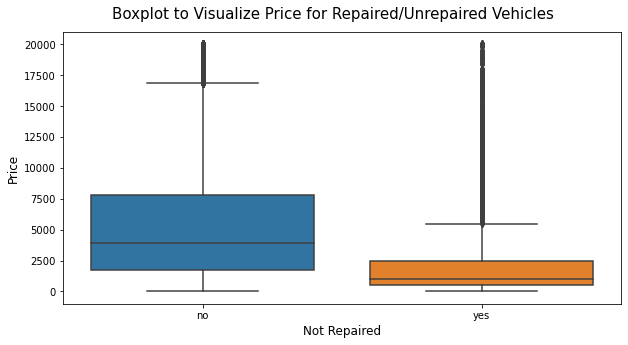

In [29]:
#Create boxplot to visualuze 'notrepaired' relation to 'price'.
fig = plt.figure(figsize=(10, 5))
plt.suptitle("Boxplot to Visualize Price for Repaired/Unrepaired Vehicles", fontsize=15, y=.95)
sns.boxplot(y='price', x='notrepaired', data=cars)
plt.xlabel('Not Repaired', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

1.3.6.4 Notes: From the boxplot we can see that there is a clear difference in price between vehicles that have and have not been repaired; however, the correlation appears to be the opposite of what we predicted. Perhaps this is due to a mistake in how the data was entered - that is, perhaps those who input the data believed that inputting 'yes' meant the vehicle was repaired. Another explanation is that used cars typically have some wear/tear, and repairing any damages prior to listing it on the market would save the buyer from paying such costs, this increasing the value of the used vehicle. Whatever the reason, we can use the apparent differences in prices for repaired and unrepaired vehicles to fill in the relevant NaNs. Given that the third quartile of vehicle prices for those marked 'yes' extends just slightly above the first quartile of prices for those vehicles marked 'no', we will set the cutoff for filling the NaNs in 'notrepaired' by vehicle price at $2400; anything above this price will be given the value of 'no' for 'notrepaired'.

In [30]:
#Create function to fill values in 'notrepaired' based on 'price'
def repaired(x):
    if pd.notna(x['notrepaired']):
        return x['notrepaired']
    else:
        if x['price'] <= 2400:
            return 'yes'
        else: 
            return 'no'

#Fill values in 'notrepaired' using apply() with lambda function.
cars['notrepaired'] = cars.apply(lambda x: repaired(x), axis=1)

##### Check for Remaining NaNs

In [31]:
#Print the number of NaNs in DataFrame.
print(f'NaNs remaining in DataFrame: {cars.isna().sum().sum()}')

NaNs remaining in DataFrame: 0


1.3.6.5 Notes: Unfortunately, in order to preserve the integrity of our data we had to drop a number of rows from our dataset where we were missing values for 'model', or where those values were marked as 'other'. On a positive note, after doing so we were able to fill the NaNs in other key columns based on 'model'. We were also able to fill all NaNs in 'notrepaired' based on the relation between 'notrepaired' values and vehicle prices.

#### Data Preprocessing Conclusion

In this subsection we preprocessed our data in order to ensure it's integrity with regard to our future machine learning models. We found that this dataset included many anomalies, outliers, and missing values. When dealing with anomalies, we used our best judgment in determining whether specific data should be kept or removed. For example, we determined that the dataset should only include information for vehicles registered latest in 2016, as the year values for 'datecrawled' were all 2016. We also found that certain 'power' values were *far* higher than any commercial car would have; as such, we used the IQR rule to remove vehicles with outlier 'power' values from the dataset. 

When filling in the NaNs, we determined that the feature that correlates most with other features that include NaNs is 'model'. In order to effectively fill in NaNs, we removed all vehicles with a NaN or 'other' value in 'model' from the dataset. We then filled in most other NaNs based on the relevant mode value each model. Finally, for the 'notrepaired' feature, we filled in the NaNs based on the vehicle's price, as we found a large difference in mean price for vehicles that have been repaired and those that haven't.

In the following section, we will build and test various machine learning models with the goal of building a model that predicts a vehicles price with a high degree of accuracy.

## Build and Test Regression Models

In this section we will build various regression models with the goal of predicting a vehicle's value. In doing so, we will compare the performance of a number of sklearn algorithms with three gradient boosting algorithms - that is, CatBoost, XGBoost, and LightGBM. Regarding the sklearn algorithms, we will search for optimal hyperparameters using GridSearchCV. For the boosting algorithms, we will test only a few different hyperparameters, given the length of time is takes to perform gradient boosting; rather than using GridSearchCV with these algorithms, we will manually tune hyperparameters using testing, training, and validation datasets.

### Build and Test Sklearn Regression Models

In this subsection we will only train and test sklearn regression models. We will build a class for creating and training models with GridSearchCV. We will then test the model and save the scores in dictionaries for later comparison. We will start this subsection by splitting the data into only training and testing datasets; since we use GridSearchCV to tune hyperparameters, validations sets will be automatically created by using one of the training folds.

#### Split the Data into Training and Learning DataSets

In [32]:
#Split the data into target and feature sets.
cars_target = cars.price
cars_features = cars.drop(columns='price', axis=1)

#Obtain list of categorical and continuous variable names.
cars_features_continuous = [x for x in cars_features.columns if cars_features[x].dtype != 'object']
cars_features_categorical = [x for x in cars_features.columns if x not in cars_features_continuous]

#One-Hot-Encode Categorical Features
cars_features_ohe = pd.get_dummies(cars_features, drop_first=True)

#Split the data into training and testing datasets with 70-30 proportion.
X_train, X_test, y_train, y_test = train_test_split(cars_features_ohe, cars_target, test_size=.3)

#### Define Scoring Function

In [33]:
#Create function to return RMSE.
def rmse_score(target, prediction):
    return round(math.sqrt(mean_squared_error(target, prediction)), 2)

#Create a scorer from rmse for GridSearchCV.
rmse = make_scorer(rmse_score, greater_is_better=False)

#### Create Class for Model Training

In [34]:
#Create class to find best models while using a pipeline to transform data.
class create_model:
    
    #Initialize model with required variables.
    def __init__(self, model, params, name):
        self.model = model
        self.params = params
        self.name = name
        self.rmse = None
        self.test_score = None
        self.best_params = None
        
    #Function for training and testing model.
    def score_it(self, scale):
        
        #Create pipeline with scaler if non-tree based algorithm.
        if scale == True:
            pipeline = Pipeline(steps=[['scale', MinMaxScaler()], 
                               ['classifier', self.model]])
        else:
            pipeline = Pipeline(steps=[['classifier', self.model]])
            
        #Use GridSearchCV to tune hyperparameters.    
        grid_search = GridSearchCV(estimator=pipeline, param_grid=self.params, scoring=rmse, cv=5, \
                           n_jobs=-1, verbose = 0, refit=True)
        
        #Fit best model and obtain relevant values.
        grid_search.fit(X_train, y_train)
        self.rmse = -1 * grid_search.best_score_
        self.test_score = -1 * grid_search.score(X_test, y_test)
        self.best_params = grid_search.best_params_

#### Train and Test Sklearn Models

In [35]:
#Create dictionary to store each model's test scores and training time.
dict_training_scores = {}
dict_test_scores = {}
dict_time = {}
dict_best_params = {}

##### DecisionTreeRegressor

In [36]:
%%time

#Start timer for saving execution time in variable.
t0 = time.time()

#Train and test DecisionTreeRegressor model.
pipe_DTR = create_model(DecisionTreeRegressor(random_state=12345), 
                          {'classifier__max_depth': range(10, 50, 10),
                           'classifier__min_impurity_decrease' : [.01, .05, .10, .15]}, "Decision Tree Regressor")

#Do not scale, as not a distance based algorithm.
pipe_DTR.score_it(False)

#Stop timer and save time.
t1 = time.time()

#Obtain model scores.
dict_test_scores[pipe_DTR.name] = pipe_DTR.test_score
dict_training_scores[pipe_DTR.name] = pipe_DTR.rmse
dict_time[pipe_DTR.name] = round(t1 - t0, 2)
dict_best_params[pipe_DTR.name] = pipe_DTR.best_params

Wall time: 1min 21s


##### SGDRegressor

In [37]:
%%time

#Start timer for saving execution time in variable.
t0 = time.time()

#Train and test LinearRegression model.
pipe_SGDR = create_model(SGDRegressor(random_state=12345), 
                        {'classifier__alpha' : [.0001, .001, .01],
                        'classifier__max_iter' : [2000],
                        'classifier__learning_rate' : ['optimal', 'invscaling']}, 
                        "Stochastic Gradient Descent Regressor")

#Scale as distance based algorithm.
pipe_SGDR.score_it(True)

#Stop timer and save time.
t1 = time.time()

#Obtain model scores.
dict_test_scores[pipe_SGDR.name] = pipe_SGDR.test_score
dict_training_scores[pipe_SGDR.name] = pipe_SGDR.rmse
dict_time[pipe_SGDR.name] = round(t1 - t0, 2)
dict_best_params[pipe_SGDR.name] = pipe_SGDR.best_params

Wall time: 10min 47s


##### RandomForestRegressor

In [38]:
%%time

#Start timer for saving execution time in variable.
t0 = time.time()

#Train and test RandomForestRegressor model.
pipe_RFG = create_model(RandomForestRegressor(random_state=12345), 
                        {'classifier__n_estimators' : [20, 50, 100],
                        'classifier__min_impurity_decrease' : [.0, .01, .05, .1]}, 
                        "Random Forest Regressor")

#Do not scale as not distance based.
pipe_RFG.score_it(False)

#Stop timer and save time.
t1 = time.time()

#Obtain model scores.
dict_test_scores[pipe_RFG.name] = pipe_RFG.test_score
dict_training_scores[pipe_RFG.name] = pipe_RFG.rmse
dict_time[pipe_RFG.name] = round(t1 - t0, 2)
dict_best_params[pipe_RFG.name] = pipe_RFG.best_params

Wall time: 37min 15s


2.1.4 Notes: As we can see, the model that trained the quickest was the Decision Tree Regressor model. The model that took, by far, the longest to find the optimal parameters for is the Random Forest Regressor. 

We've saved all the scores and training times in dictionaries and will provide a detailed conclusion regarding the values after training and testing our gradient boosting models. We will also use build a Linear Regression model at the end for a sanity check.

### Build and Test Gradient Boosting Models

#### Prepare the Data

In [39]:
#Create new datasets for gradient boosting.
cars_gb = cars.copy()
cars_gb_ohe = pd.get_dummies(cars_gb, drop_first=True)

#Create list of featues for both datasets.
cars_gb_feat = [x for x in cars_gb.columns if x != 'price']
cars_gb_ohe_feat = [x for x in cars_gb_ohe.columns if x != 'price']

#Obtain list of categorical variable names for non-OHE dataset.
cars_gb_feat_cat = [x for x in cars_features.columns if cars_features[x].dtype == 'object']

#Change categorical features in non-OHE dataset to dtype 'category'.
for c in cars_gb_feat_cat:
    cars_gb[c] = cars_gb[c].astype('category')

#Split non-OHE dataset into train, validate, and test sets (60-20-20).
train_gb, validate_gb, test_gb = np.split(cars_gb.sample(frac=1), [int(.6*len(cars_gb)), int(.8*len(cars_gb))])

#Split OHE dataset into train, validate, and test sets (60-20-20).
train_gb_ohe, validate_gb_ohe, test_gb_ohe = np.split(cars_gb_ohe.sample(frac=1), [int(.6*len(cars_gb_ohe)), int(.8*len(cars_gb_ohe))])

#### Build and Test Models

##### CatBoostRegressor

In [40]:
%%time

#Start timer for saving execution time in variable.
t0 = time.time()

#Create variables for best learning rate and test score.
best_rate = 0
best_valid_rmse = 0

#Create for loop to tune learning_rate hyperparameter of CatBoostRegressor.
for i in np.arange(.01, .1, .01):
    catboost = CatBoostRegressor(random_state=12345, loss_function='RMSE', learning_rate=i, verbose=0)
    catboost.fit(train_gb[cars_gb_feat], train_gb['price'], cat_features=cars_gb_feat_cat)
    predicted = catboost.predict(validate_gb[cars_gb_feat])
    valid_rmse = rmse_score(validate_gb['price'], predicted)
    if best_valid_rmse == 0:
        best_valid_rmse = valid_rmse
        best_rate = i
    elif valid_rmse < best_valid_rmse:
        best_valid_rmse = valid_rmse
        best_rate = i
    else:
        continue

#Using best hyperparameter identified, fit and predict model.
catboost = CatBoostRegressor(random_state=12345, loss_function='RMSE', learning_rate=best_rate, verbose=0)
catboost.fit(train_gb[cars_gb_feat], train_gb['price'], cat_features=cars_gb_feat_cat)
predicted = catboost.predict(test_gb[cars_gb_feat])

#Stop timer and save time.
t1 = time.time()

#Obtain model scores.
dict_test_scores['CatBoostRegressor'] = rmse_score(test_gb['price'], predicted)
dict_training_scores['CatBoostRegressor'] = best_valid_rmse
dict_time['CatBoostRegressor'] = round(t1 - t0, 2)
dict_best_params['CatBoostRegressor'] = f'learning_rate: {best_rate}'

Wall time: 7min 35s


##### XGBRegressor

In [45]:
%%time

#Start timer for saving execution time in variable.
t0 = time.time()

#Create variables for best learning rate and test score.
best_rate_XG = 0
best_valid_rmse_XG = 0

#Create for loop to tune learning_rate hyperparameter of XGBoost.
for i in np.arange(.01, .1, .01):
    xgboost = XGBRegressor(random_state=12345, eval_metric='rmse', learning_rate=i)
    xgboost.fit(train_gb_ohe[cars_gb_ohe_feat], train_gb_ohe['price'])
    predicted = xgboost.predict(validate_gb_ohe[cars_gb_ohe_feat])
    valid_rmse = rmse_score(validate_gb_ohe['price'], predicted)
    if best_valid_rmse_XG == 0:
        best_valid_rmse_XG = valid_rmse
        best_rate_XG = i
    elif valid_rmse < best_valid_rmse_XG:
        best_valid_rmse = valid_rmse
        best_rate_XG = i
    else:
        continue

#Using best hyperparameter identified, fit and predict model.
xgboost = XGBRegressor(random_state=12345, eval_metric='rmse', learning_rate=best_rate_XG)
xgboost.fit(train_gb_ohe[cars_gb_ohe_feat], train_gb_ohe['price'])
predicted = xgboost.predict(test_gb_ohe[cars_gb_ohe_feat])

#Stop timer and save time.
t1 = time.time()

#Obtain model scores.
dict_test_scores['XGBRegressor'] = rmse_score(test_gb_ohe['price'], predicted)
dict_training_scores['XGBRegressor'] = best_valid_rmse_XG
dict_time['XGBRegressor'] = round(t1 - t0, 2)
dict_best_params['XGBRegressor'] = f'learning_rate: {best_rate_XG}'

Wall time: 3min 48s


##### LGBMRegressor

In [42]:
%%time

#Start timer for saving execution time in variable.
t0 = time.time()

#Create variables for best learning rate and test score.
best_rate_GB = 0
best_valid_rmse_GB = 0

#Create for loop to tune learning_rate hyperparameter of LightGBM.
for i in np.arange(.01, .1, .01):
    LGMB = LGBMRegressor(random_state=12345, objective='regression', metric='rmse', learning_rate=i,
                         verbosity = 0, force_row_wise='true')
    LGMB.fit(train_gb[cars_gb_feat], train_gb['price'])
    predicted = LGMB.predict(validate_gb[cars_gb_feat])
    valid_rmse = rmse_score(validate_gb['price'], predicted)
    if best_valid_rmse_GB == 0:
        best_valid_rmse_GB = valid_rmse
        best_rate_GB = i
    elif valid_rmse < best_valid_rmse_GB:
        best_valid_rmse_GB = valid_rmse
        best_rate_GB = i
    else:
        continue
        
#Using best hyperparameter identified, fit and predict model.
LGMB = LGBMRegressor(random_state=12345, objective='regression', metric='rmse', 
                     learning_rate=best_rate_GB, verbosity=0, force_row_wise='true')
LGMB.fit(train_gb[cars_gb_feat], train_gb['price'])
predicted = LGMB.predict(test_gb[cars_gb_feat])

#Stop timer and save time.
t1 = time.time()

#Obtain model scores.
dict_test_scores['LGBMRegressor'] = rmse_score(test_gb['price'], predicted)
dict_training_scores['LGBMRegressor'] = best_valid_rmse_GB
dict_time['LGBMRegressor'] = round(t1 - t0, 2)
dict_best_params['LGBMRegressor'] = f'learning_rate: {best_rate_GB}'

Wall time: 6.17 s


### Build a Sanity Check Model - Linear Regression

#### Train and Test Linear Regression Model

In [43]:
%%time

#Start timer for saving execution time in variable.
t0 = time.time()

#Create intance of LinearRegression model.
pipe_lnr = create_model(LinearRegression(), {}, "LinearRegression")

#Do not scale.
pipe_lnr.score_it(False)

#Stop timer and save time.
t1 = time.time()

#Obtain scores for LinearRegression model.
dict_training_scores['LinearRegression'] = pipe_lnr.test_score
dict_test_scores['LinearRegression'] = pipe_lnr.rmse
dict_time['LinearRegression'] = round(t1 - t0, 2)
dict_best_params['LinearRegression'] = pipe_lnr.best_params

Wall time: 8.79 s


### Section Conclusion

In [46]:
#Create DataFrame from scores.
mydicts = [dict_training_scores, dict_test_scores, dict_time]
final_scores = pd.concat([pd.Series(d) for d in mydicts], axis=1)
final_scores.columns = ['RMSE Train', "RMSE Test", "Time"]
final_scores.sort_values('RMSE Test', ascending=True, inplace=True)

#Display final scores.
display(final_scores)

,RMSE Train,RMSE Test,Time
CatBoostRegressor,1410.770,1404.32,455.80
LGBMRegressor,1425.560,1412.12,6.17
Random Forest Regressor,1501.264,1456.93,2235.65
XGBRegressor,2986.090,1482.94,228.60
Decision Tree Regressor,1775.312,1698.79,81.81
Stochastic Gradient Descent Regressor,2337.690,2301.41,647.55
LinearRegression,2300.130,2332.56,8.79


As we can see from the above DataFrame, the model that provided the best RMSE score for the test dataset is the CatBoostRegressor model. This model performed far better than the sanity model, which was simply based on linear regression, and was relatively quick. By far the worst performing models, with regard to the test dataset RMSE score, are LinearRegression and Stochastic Gradient Descent Regressor; both of these models proved to be quite poor, and the latter took over 10 minutes to train using various hyperparameters.

## Conclusion

The overall aim of this project was to build a model that is adept at predicting a vehicle's price based on various hyperparameters. Rusty Bargain wanted a model that is not only reliable, but also quick. Before building any models, we made sure to preprocess the data, which involved deleting anomalies and outliers, deleting duplicates, and changing data types.

To build models, first created a class that conducts cross validation using GridSearchCV while tuning hyperparameters; we only used this class for training Sklean models. For gradient boosting models, we manually tuned hyperparameters in order to avoid any possible complications that may result from the utilization of their relevant libraries with Sklearn's GridSearchCV.

As we saw in the above DataFrame, the model that performed the best was the CatBoostRegressor model; not only did it offer the best RMSE score, but it also only took 8 minutes to train. That being said, in training the model we manually iterated through 9 different values for 'learning_rate', which resulted in the cell requiring more time to complete the process; if we divide the amount of time it took to iterate through hyperparameters by the number of parameters tested, we find that CatBoostRegressor took under 1 minute to fit the model.

It's interesting to note that not far from CatBoostRegressor is the LGBMRegressor. This algorithm produces scores slightly higher than CatBoostRegressor, yet the model training time was less than 6 seconds. 

After building and testing various models, we would like to offer the following recommendations to Rusty Bargain:

    1) If the accuracy or predictions is far more important than algorithm speed, then it would be best to select the CatBoostRegressor model for predicting vehicle prices. The model is relatively quick and provides the best RMSE scores of all the models tested.

    2) If the speed of an algorithm is quite important, second to accuracy, then the LGBMRegressor model would be best to select. While the model didn't provide the best scores, they were very close to the CatBoostRegressor scores. Moreover, the time it took to train the algorithm was far lower than the time it took to train the CatBoostRegressor algorithm, even though we iterated through various learning_rate values.

We believe that whichever of the abovementioned models is chosen, Rusty Bargain will be happy with the outcome.